<a href="https://colab.research.google.com/github/chigvintseva/UniProject-simulation-techniques/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data generation**

In [1]:
import numpy as np
import pandas as pd

1. Set random seed for reproducibility

In [2]:
# to ensure the reproducable synthetic data generation
np.random.seed(42)

2. Generate patient arrival times using poisson process

In [3]:
arrival_rate_per_hour = 10
simulation_duration_hours = 24

#total patient count
num_patients = np.random.poisson(lam=arrival_rate_per_hour * simulation_duration_hours)

In [4]:
#inter-arrival times (in hours) from exponential distribution
inter_arrival_times = np.random.exponential(scale=1/arrival_rate_per_hour, size=num_patients)

In [5]:
#cumulative arrival times
arrival_times = np.cumsum(inter_arrival_times)

Arrivals example for data verfification:

In [27]:
print("Sample of Patient Arrival Times:")
for i, arrival in enumerate(arrival_times[:5], start=1):
    hours = int(arrival)
    minutes = int((arrival - hours) * 60)
    print(f"  Patient {i}: {hours} hours and {minutes} minutes after simulation start")

Sample of Patient Arrival Times:
  Patient 1: 0 hours and 7 minutes after simulation start
  Patient 2: 0 hours and 13 minutes after simulation start
  Patient 3: 0 hours and 14 minutes after simulation start
  Patient 4: 0 hours and 15 minutes after simulation start
  Patient 5: 0 hours and 15 minutes after simulation start


3. Assign Triage Categories with Weighted Sampling

In [11]:
# triage levels and their empirical probabilities
triage_levels = [1, 2, 3, 4, 5]
triage_probabilities = [0.1, 0.2, 0.3, 0.25, 0.15]

In [12]:
#random assign triage categories to each patient
assigned_triage = np.random.choice(triage_levels, size=num_patients, p=triage_probabilities)

In [13]:
# Display normalized frequency distribution
print("Normalized triage distribution:")
print(pd.Series(assigned_triage).value_counts(normalize=True).sort_index())

Normalized triage distribution:
1    0.145299
2    0.145299
3    0.282051
4    0.256410
5    0.170940
Name: proportion, dtype: float64


Visualisation of the triage distribution

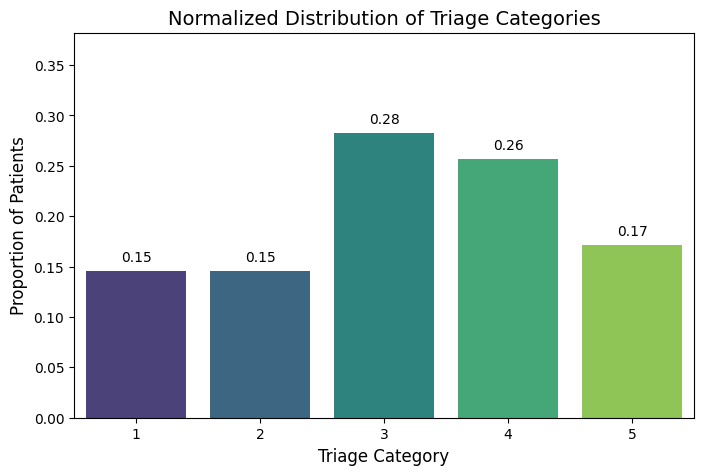

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

triage_counts = pd.Series(assigned_triage).value_counts(normalize=True).sort_index()
triage_levels = triage_counts.index.astype(str)
frequencies = triage_counts.values

plt.figure(figsize=(8, 5))
sns.barplot(x=triage_levels, y=frequencies, hue=triage_levels, palette="viridis", dodge=False, legend=False)

plt.xlabel('Triage Category', fontsize=12)
plt.ylabel('Proportion of Patients', fontsize=12)
plt.title('Normalized Distribution of Triage Categories', fontsize=14)

#Show proportion values on top of bars
for i, freq in enumerate(frequencies):
    plt.text(i, freq + 0.01, f'{freq:.2f}', ha='center', fontsize=10)
plt.ylim(0, max(frequencies) + 0.1)
plt.show()

4. Simulate diagnostic testing requirements with Bernoulli Trials

In [17]:
#probability of requiring diagn. testing - 40% is typical for clinical studies
diagnostic_probability = 0.4

In [18]:
# binary diagnostic requirement flags to patients
requires_diagnostics = np.random.binomial(n=1, p=diagnostic_probability, size=num_patients)

In [19]:
print(f"Percentage of patients requiring diagnostics: {requires_diagnostics.mean() * 100:.2f}%")

Percentage of patients requiring diagnostics: 35.90%


**5. Sample process durations using Triangular Distributions**

to avoid zero to negative values & return array of samples.

parameters:

*  minimum: minimum value of distribution
*  mode: most likely (peak) value
*  maximum: maximum value
*  sample_size: number of samples to generate

In [20]:
def triangular_sample(minimum, mode, maximum, sample_size):
  samples = np.random.triangular(left=minimum, mode=mode, right=maximum, size=sample_size)
  return np.clip(samples, a_min=0.1, a_max=None)  # ensures positive durations

In [21]:
# sample process durations in minutes for each patient

triage_times = triangular_sample(5, 10, 15, num_patients)
registration_times = triangular_sample(3, 7, 12, num_patients)
consultation_times = triangular_sample(15, 25, 40, num_patients)
diagnostic_times = triangular_sample(20, 30, 45, num_patients)
treatment_times = triangular_sample(10, 20, 35, num_patients)

In [22]:
# setting diagnostics to 0 for pations not requiring it
diagnostic_times *= requires_diagnostics

In [26]:
print("Sample of Consultation Times (minutes):")
for i, time in enumerate(consultation_times[:5], start=1):
    print(f"  Patient {i}: {time:.2f} minutes")

Sample of Consultation Times (minutes):
  Patient 1: 28.25 minutes
  Patient 2: 23.06 minutes
  Patient 3: 28.28 minutes
  Patient 4: 26.87 minutes
  Patient 5: 30.91 minutes


6. Gather generated variables into chronologically ordered dataset for further simulation (both control and manipulated scenarios)

In [29]:
ed_patient_data = pd.DataFrame({
    'arrival_time_hr': arrival_times,   #hours since simulation start
    'triage_category': assigned_triage,  #triage levels 1–5
    'requires_diagnostics': requires_diagnostics,   #booleans
    'triage_time_min': triage_times,  #continuous var-s, process durations in minutes
    'registration_time_min': registration_times,
    'consultation_time_min': consultation_times,
    'diagnostic_time_min': diagnostic_times,
    'treatment_time_min': treatment_times
})

In [30]:
#sort dataset by arrival time to ensure the correct event sequencing
ed_patient_data.sort_values('arrival_time_hr', inplace=True)
ed_patient_data.reset_index(drop=True, inplace=True)

In [43]:
# how the dataset looks like (what's stored inside, not easy to analyse)
print(ed_patient_data.head())

   arrival_time_hr  triage_category  requires_diagnostics  triage_time_min  \
0         0.131675                2                     0         6.780098   
1         0.222969                1                     1        14.291489   
2         0.239931                4                     0         9.014685   
3         0.256891                2                     1        11.916775   
4         0.262875                5                     0         8.568197   

   registration_time_min  consultation_time_min  diagnostic_time_min  \
0               5.058893              28.249684             0.000000   
1               7.634595              23.059212            36.463391   
2               6.141017              28.284717             0.000000   
3               7.520939              26.865866            37.971610   
4               8.039434              30.913858             0.000000   

   treatment_time_min  
0           21.865462  
1           27.303409  
2           21.596987  
3 

In [44]:
print("Sample of Generated Patient Data (first 5 rows):\n")

# Select relevant columns for display
sample = ed_patient_data.head()

# Rename columns with descriptive headers for clarity
sample = sample.rename(columns={
    'arrival_time_hr': 'Arrival',
    'triage_category': 'TriageCat.',
    'requires_diagnostics': 'Needs Diagn.?',
    'triage_time_min': 'Triage(min)',
    'registration_time_min': 'Registr.(min)',
    'consultation_time_min': 'Consult.(min)',
    'diagnostic_time_min': 'Diagnostic(min)',
    'treatment_time_min': 'Treatment(min)'
})

print(sample.to_string(index=False))

Sample of Generated Patient Data (first 5 rows):

 Arrival  TriageCat.  Needs Diagn.?  Triage(min)  Registr.(min)  Consult.(min)  Diagnostic(min)  Treatment(min)
0.131675           2              0     6.780098       5.058893      28.249684         0.000000       21.865462
0.222969           1              1    14.291489       7.634595      23.059212        36.463391       27.303409
0.239931           4              0     9.014685       6.141017      28.284717         0.000000       21.596987
0.256891           2              1    11.916775       7.520939      26.865866        37.971610       23.119118
0.262875           5              0     8.568197       8.039434      30.913858         0.000000       14.720287


Visuals of the dataset by triage category

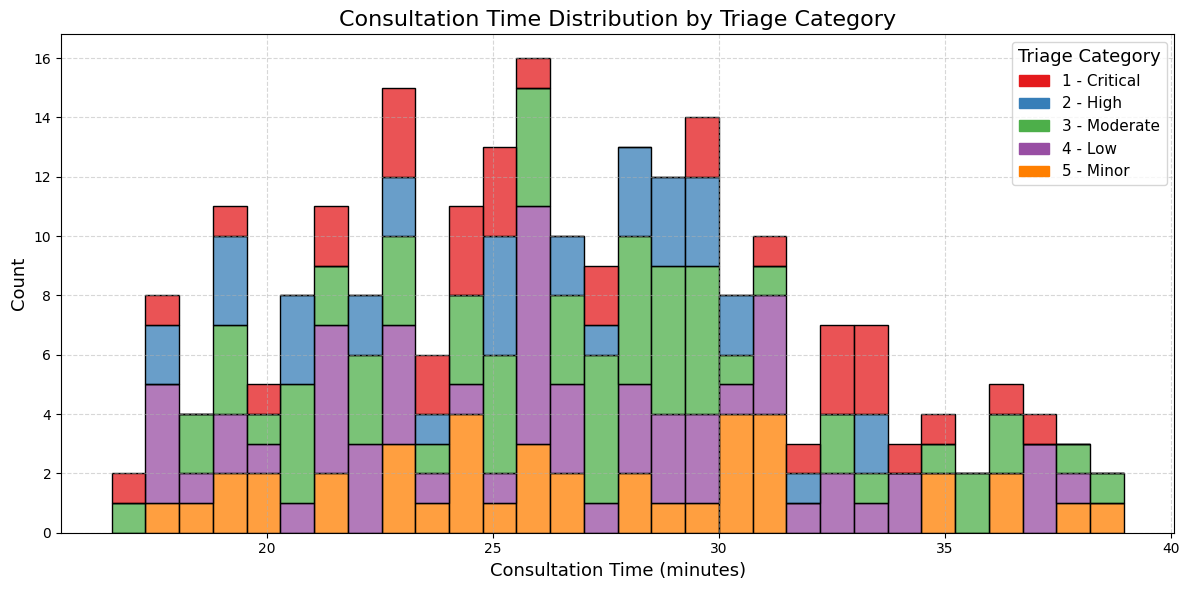

In [52]:
import matplotlib.patches as mpatches

plt.figure(figsize=(12, 6))
hist = sns.histplot(
    data=plot_data,
    x='consultation_time_min',
    hue='triage_category',
    multiple='stack',
    palette=palette,
    bins=30,
    edgecolor='black',
    alpha=0.75
)

plt.title('Consultation Time Distribution by Triage Category', fontsize=16)
plt.xlabel('Consultation Time (minutes)', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

triage_labels = ['1 - Critical', '2 - High', '3 - Moderate', '4 - Low', '5 - Minor']
handles = [mpatches.Patch(color=palette[i], label=triage_labels[i]) for i in range(len(triage_labels))]

plt.legend(handles=handles, title='Triage Category', title_fontsize=13, fontsize=11, loc='upper right')

plt.show()